# Creating a motif finder: A test file
This file will go through the steps of producing a motif finder that isolates all 120U triads in a given network.
1. Import data and create edgelist
2. Add edges to a networkx graph object
3. Use the .succesors() functions to find what each individual node is connected to
4. Check what formations are used
5. Isolate the reciprocal pair of nodes from the convergent node


In [39]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import pickle
from itertools import combinations, permutations
from collections import defaultdict
import matplotlib.pyplot as plt
import unittest
# only allow 100 rows to display pandas
pd.set_option('display.max_rows', 100)

In [3]:
# Import data
syn_table = pd.read_csv('/Users/rweberla/Downloads/connections.csv')
syn_table

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940629970489,720575940631267655,AVLP_R,7,GABA
1,720575940605876866,720575940606514878,LAL_R,15,GABA
2,720575940627737365,720575940628914436,AL_L,32,ACH
3,720575940633587552,720575940626452879,SMP_R,15,ACH
4,720575940616871878,720575940621203973,AVLP_L,13,GABA
...,...,...,...,...,...
3869873,720575940621773517,720575940611139733,PVLP_R,1,ACH
3869874,720575940622734576,720575940609171395,ICL_L,2,ACH
3869875,720575940638466367,720575940627036426,LO_L,5,ACH
3869876,720575940629789660,720575940631553603,GOR_R,3,ACH


In [5]:
# Create edgelist
syn_table_limit_test = syn_table[["pre_root_id", "post_root_id"]]
syn_table_limit_test 

,pre_root_id,post_root_id
0,720575940629970489,720575940631267655
1,720575940605876866,720575940606514878
2,720575940627737365,720575940628914436
3,720575940633587552,720575940626452879
4,720575940616871878,720575940621203973
...,...,...
3869873,720575940621773517,720575940611139733
3869874,720575940622734576,720575940609171395
3869875,720575940638466367,720575940627036426
3869876,720575940629789660,720575940631553603


### Found this function called succesors in networkx!
This allows you to create a directed graph and find all triads in this reference:
- Snijders, T. (2012). “Transitivity and triads.” University of Oxford. https://web.archive.org/web/20170830032057/http://www.stats.ox.ac.uk/~snijders/Trans_Triads_ha.pdf

Our motif is the "120U". We will probably need to use the HPC to do the whole connectome. 

This method was developed with help from co-pilot. The testing was done with df_test

In [7]:
# Isolated test for exact motif we want
e_test= [(10,21), (21,10), (21,11), (10,11)]
df_test = pd.DataFrame(columns=["s", "t"], data = e_test)
df_test

,s,t
0,10,21
1,21,10
2,21,11
3,10,11


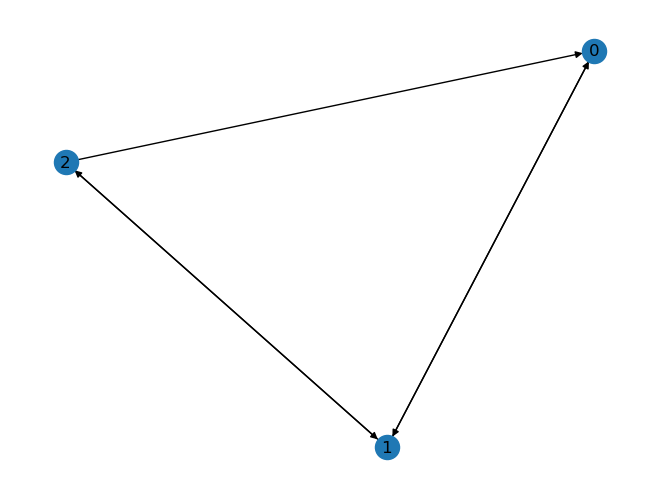

In [58]:
G = nx.DiGraph()
G.add_edges_from([(0, 1), (1, 0), (2, 0), (2, 1), (1, 2)])
nx.draw(G, with_labels=True)

In [59]:
# How does successors work?
# This seems to access the nodes that the parameterized node points to
for i, a in enumerate(G.nodes()):
    print(a)

0
1
2


In [64]:
# Now I want to see if we can get the successors of the successors
# This is the same as the neighbors function
for i, a in enumerate(G.nodes()):
    print("\n")
    print("a", a)
    for b in G.successors(a):
        print("successor of a", b)
        for c in G.successors(a):
            print("successor of a2", c)
            



a 0
successor of a 1
successor of a2 1


a 1
successor of a 0
successor of a2 0
successor of a2 2
successor of a 2
successor of a2 0
successor of a2 2


a 2
successor of a 0
successor of a2 0
successor of a2 1
successor of a 1
successor of a2 0
successor of a2 1


In [29]:
# Now I want to check for our triad with the data we have
for i, a in enumerate(G.nodes()):
    print("\n")
    print("a", a)
    for i in G.successors(a):
        print("successor of a", i)
        for j in G.successors(a):
            print("successor of i", j)
            if i != j and G.has_edge(j, a) and G.has_edge(j, i):
                print(i, j, a)
                print("True")



a 10
successor of a 21
successor of i 21
successor of i 11
successor of a 11
successor of i 21
11 21 10
True
successor of i 11


a 21
successor of a 10
successor of i 10
successor of i 11
successor of a 11
successor of i 10
11 10 21
True
successor of i 11


a 11


In [32]:
# checking for reciprocal edges
for i, a in enumerate(G.nodes()):
    print("\n")
    print("a", a)
    for i in G.successors(a):
        print("successor of a", i)
        for j in G.successors(a):
            print("successor of i", j)
            if i != j and G.has_edge(j, a) and G.has_edge(j, i):
                    # Checks which nodes are reciprocal and sets the third node as the remaining node
                    if G.has_edge(a, i) and G.has_edge(i, a):
                        print(a, i)
                        reciprocal_nodes = (a, i)
                        third_node = j
                    elif G.has_edge(a, j) and G.has_edge(j,a):
                        print(a, j)
                        reciprocal_nodes = (a, j)
                        third_node = i
                    elif G.has_edge(i, j) and G.has_edge(j, i):
                        print(i, j)
                        reciprocal_nodes = (i, j)
                        third_node = a



a 10
successor of a 21
successor of i 21
successor of i 11
successor of a 11
successor of i 21
10 21
successor of i 11


a 21
successor of a 10
successor of i 10
successor of i 11
successor of a 11
successor of i 10
21 10
successor of i 11


a 11


In [87]:
# Put it all together with a counter
def count_triads(G):
    num_120U_triads = 0
    tri_by_type = defaultdict(list)
    unique_triads = set()

    print("Starting to count triads")
    for i, A in enumerate(G.nodes()):
        # Find all successors of A
        for B in G.successors(A):
            for C in G.successors(A):
                if B != C and G.has_edge(C, A) and G.has_edge(C, B):
                    # Sort the nodes to ensure consistency
                    triad = tuple(sorted([A, B, C]))
                    if triad not in unique_triads:
                        unique_triads.add(triad)
                        # Identify the reciprocal nodes and the third node
                        if G.has_edge(A, B) and G.has_edge(B, A) and not G.has_edge(C, A) and not G.has_edge(C, B):
                            reciprocal_nodes = (A, B)
                            third_node = C
                        elif G.has_edge(A, C) and G.has_edge(C, A) and not G.has_edge(B, A) and not G.has_edge(B, C):
                            reciprocal_nodes = (A, C)
                            third_node = B
                        elif G.has_edge(B, C) and G.has_edge(C, B) and not G.has_edge(A, B) and not G.has_edge(A, C):
                            reciprocal_nodes = (B, C)
                            third_node = A
                        else:
                            continue
                        tri_by_type["120U"].append([reciprocal_nodes,third_node])
                        num_120U_triads += 1

        if (i+1)%10000 == 0:
            print(f"Processed {i} nodes")
            print(f"Found {num_120U_triads} 120U triads")
    return num_120U_triads, tri_by_type

## Testing the function
This will be 4 parts:
- testing how it acts if there aren't any triads to find
- testing how the functions acts if there is a more complex motif that includes the 120U motif
- testing how the functions acts if there are multiple motifs
- testing that there are no false positives

### No motifs

Starting to count triads


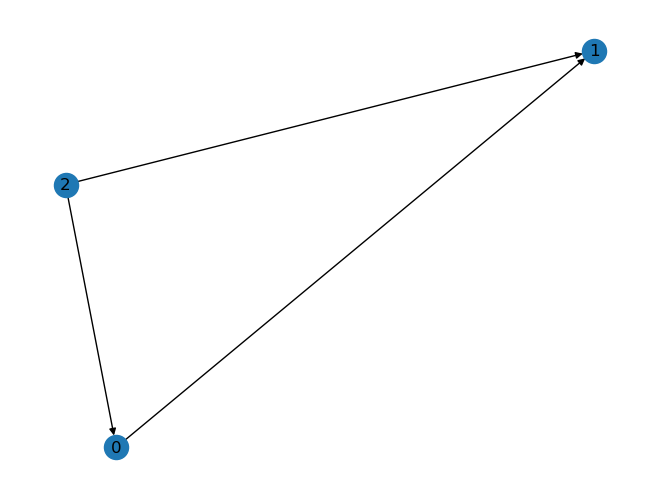

In [88]:
G = nx.DiGraph()
G.add_edges_from([(0, 1), (2, 1), (2, 0)])
nx.draw(G, with_labels=True)
num_120U_triads, tri_by_type = count_triads(G)
# assert equal to zero
assert num_120U_triads == 0

### More complex motif in graph including 120U motif
The question here is if we want this motif to be included here, as our motif is technically in here but also have more edges

Starting to count triads


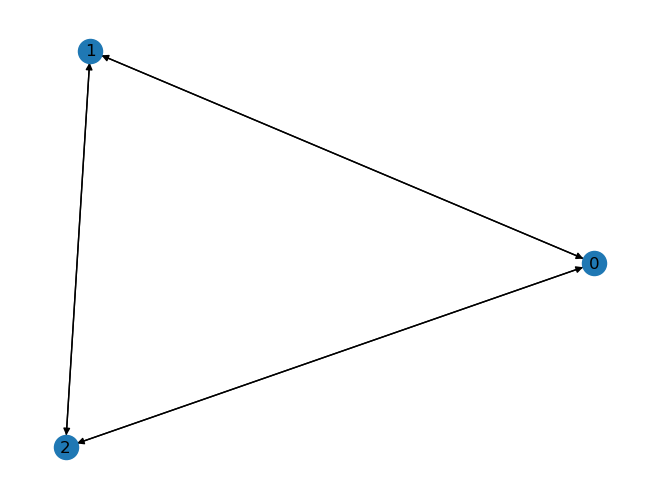

In [89]:
G = nx.DiGraph()
G.add_edges_from([(0, 1), (1, 0), (0, 2), (2, 0), (2, 1), (1, 2)])
nx.draw(G, with_labels=True)
num_120U_triads, tri_by_type = count_triads(G)
assert num_120U_triads == 0


Starting to count triads
defaultdict(<class 'list'>, {})


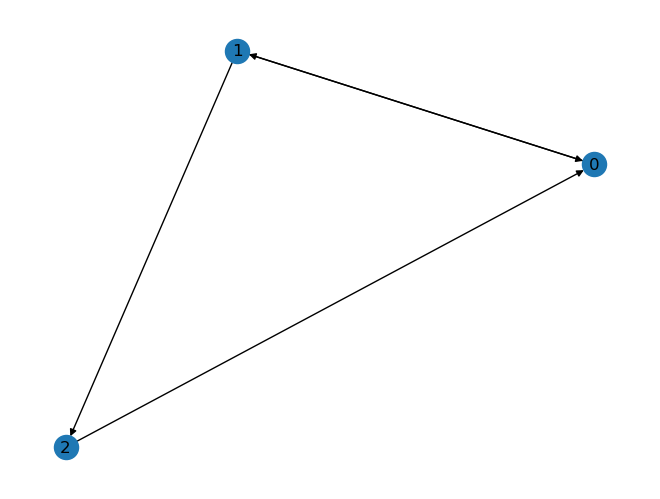

In [90]:
G = nx.DiGraph()
G.add_edges_from([(0, 1), (1, 0), (2, 0), (1, 2)])
nx.draw(G, with_labels=True)
num_120U_triads, tri_by_type = count_triads(G)
assert num_120U_triads == 0
print(tri_by_type)


### No false positives

Starting to count triads
2


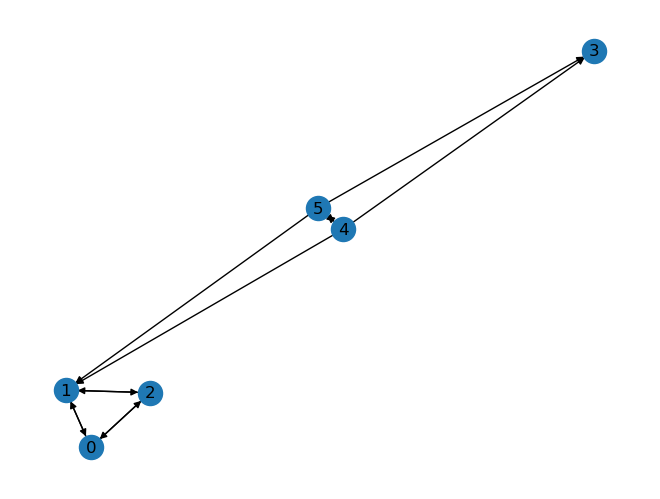

In [95]:
G = nx.DiGraph()
G.add_edges_from([(0, 1), (1, 0), (0, 2), (2, 0), (2, 1), (1, 2), (4, 3), (5, 3), (5, 4), (4, 5), (5, 1), (4,1)])
nx.draw(G, with_labels=True)
num_120U_triads, tri_by_type = count_triads(G)
print(num_120U_triads)
assert num_120U_triads == 2

## Running function on our data

In [96]:
# Run on the full dataset (takes a minute)
G = nx.DiGraph()
# Add the edges to the graph from dataframe
G.add_edges_from(syn_table_limit_test.values)

# Count the number of 120U triads
num_120U_triads, tri_by_type = count_triads(G)

Starting to count triads
Processed 9999 nodes
Found 337632 120U triads
Processed 19999 nodes
Found 570772 120U triads
Processed 29999 nodes
Found 654686 120U triads
Processed 39999 nodes
Found 695687 120U triads
Processed 49999 nodes
Found 718999 120U triads
Processed 59999 nodes
Found 732711 120U triads
Processed 69999 nodes
Found 741112 120U triads
Processed 79999 nodes
Found 745916 120U triads
Processed 89999 nodes
Found 748660 120U triads
Processed 99999 nodes
Found 750061 120U triads
Processed 109999 nodes
Found 750592 120U triads
Processed 119999 nodes
Found 750714 120U triads
Processed 129999 nodes
Found 750733 120U triads


In [97]:
# Save tri_by_type to a txt file, /Users/rweberla/Downloads/wholeNet_120U_triads.txt
with open('/Users/rweberla/Downloads/wholeNet_120U_triads.txt', 'w') as f:
    for item in tri_by_type["120U"]:
        f.write("%s\n" % item)


In [38]:
num_120U_triads

1506182

This next part will be 
1. a for loop that iterates through the triads of df_found 
2. syn_table_f is filtered for just the edges in that triad (all possible combos)
3. those rows (plus all columns) will be attached to df_triad_final
4. the triad index will be the triad index from the df_found, for example for each connection that makes up the triad in the first row of df_found (index=0), their indexes will be 0 in the df_traid_final dataframe, so around 4 of them should be 0 since they are all 120U

In [80]:
# Create a dataframe wtih multiIndex and populate traid column to 286724 rows all with 0
# a for loop that iterates through the rows of df_found
def triad_info(df):
    df_new = pd.DataFrame(columns=["pre_root_id", "post_root_id", "neuropil", "syn_count", 'nt_type', 'triad'])
    for index, row in df.iterrows():
        # For large set runs:
        if (index+1)%10000 == 0:
            print("10000 done!")
        
        # Find the pre_root_id and post_root_id of the edge1, edge2, and edge3
        id_1 = int(row["reciprocal1"])
        id_2 = int(row["reciprocal2"])
        id_3 = int(row["nid"])
        
        # Find connections in the syn_table_f that match the combinations of id_1, id_2, and id_3
        # use combinations to find all possible combinations of the 3 ids
        for comb in permutations([id_1, id_2, id_3], 2):

            # Find the rows that match the combinations
            rows = syn_table[(syn_table["pre_root_id"] == comb[0]) & (syn_table["post_root_id"] == comb[1])]
            
            # If there are rows that match the combinations
            if not rows.empty:
                # Add the triad value to the rows
                rows["triad"] = index+1
                # Add the rows to the df_new dataframe
                df_new = pd.concat([df_new, rows]).reset_index(drop=True)

    return df_new